## Age and Gender Detection System. 

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [3]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [4]:
import os

# Specify the path to the folder
folder_path = "/OneDrive/Desktop/Data Science/Age and Gender Detection System/UTKFace"



In [5]:
import os
import random
from tqdm import tqdm

BASE_DIR = r"C:\Users\pjaga\OneDrive\Desktop\Data Science\Age and Gender Detection System\UTKFace"
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)


100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 124508.62it/s]


In [6]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [7]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [8]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,C:\Users\pjaga\OneDrive\Desktop\Data Science\A...,50,0
1,C:\Users\pjaga\OneDrive\Desktop\Data Science\A...,26,1
2,C:\Users\pjaga\OneDrive\Desktop\Data Science\A...,26,0
3,C:\Users\pjaga\OneDrive\Desktop\Data Science\A...,20,1
4,C:\Users\pjaga\OneDrive\Desktop\Data Science\A...,60,1


## Exploratory Data Anlysis

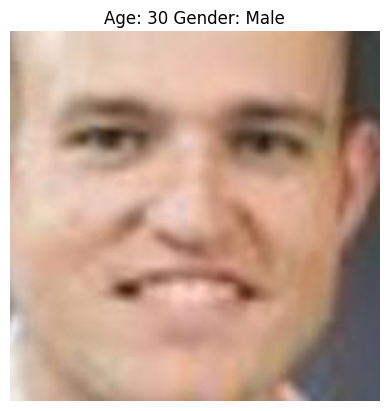

In [9]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<AxesSubplot:xlabel='age', ylabel='Density'>

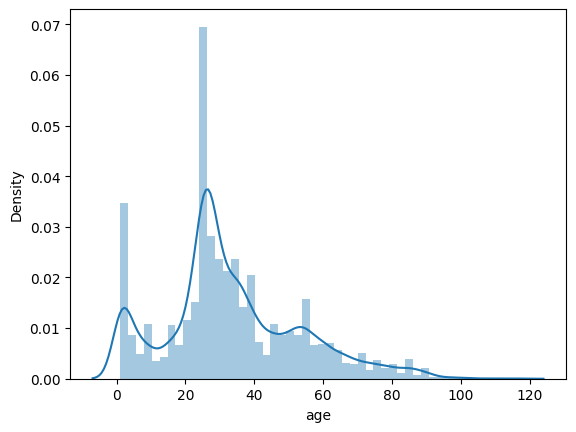

In [10]:
 # Age distribution
 sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

<AxesSubplot:ylabel='count'>

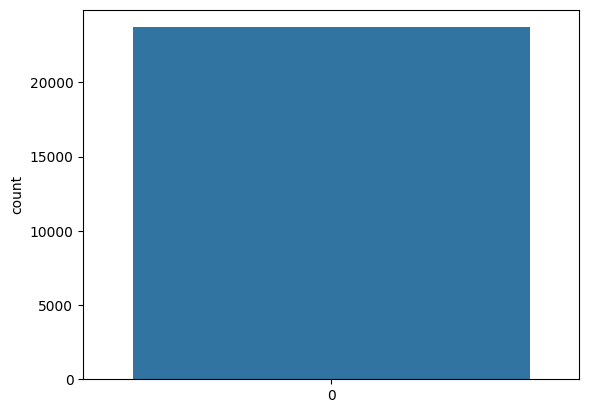

In [11]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

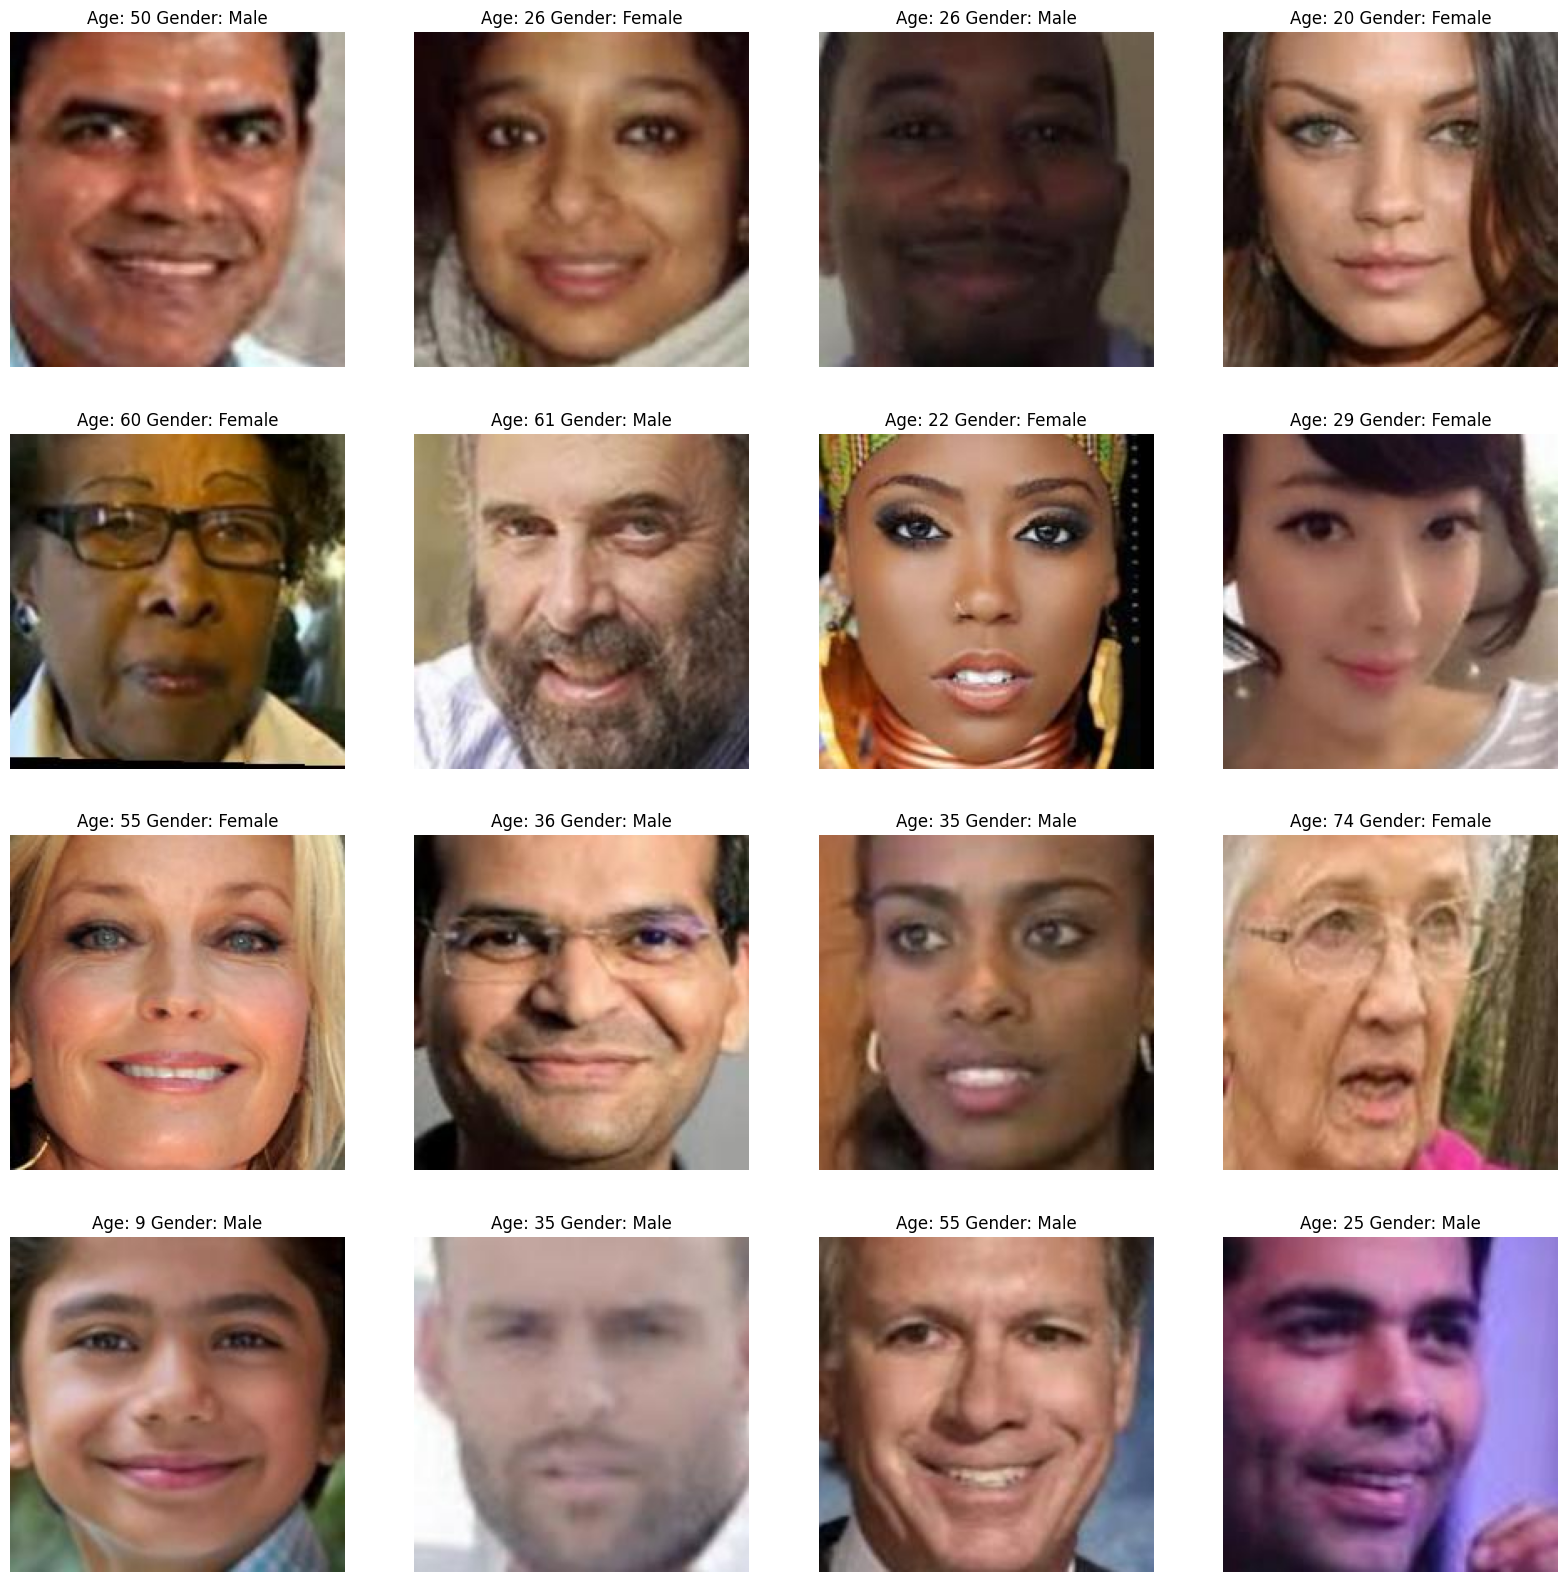

In [12]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction

In [13]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [14]:
X = extract_image_features(df['image_path'])

100%|███████████████████████████████████████████████████████████████████████████| 23708/23708 [03:44<00:00, 105.77it/s]


In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
X = X / 255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

In [19]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

In [20]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 1358s 2s/step - loss: 16.1873 - gender_out_loss: 0.6959 - age_out_loss: 15.4914 - gender_out_accuracy: 0.5211 - age_out_accuracy: 0.0477 - val_loss: 15.8300 - val_gender_out_loss: 0.6851 - val_age_out_loss: 15.1449 - val_gender_out_accuracy: 0.6636 - val_age_out_accuracy: 0.0458
Epoch 2/10
593/593 [==============================] - 457s 770ms/step - loss: 12.2009 - gender_out_loss: 0.5357 - age_out_loss: 11.6652 - gender_out_accuracy: 0.7304 - age_out_accuracy: 0.0445 - val_loss: 10.3585 - val_gender_out_loss: 0.4301 - val_age_out_loss: 9.9284 - val_gender_out_accuracy: 0.7938 - val_age_out_accuracy: 0.0424
Epoch 3/10
593/593 [==============================] - 523s 882ms/step - loss: 9.9530 - gender_out_loss: 0.4259 - age_out_loss: 9.5270 - gender_out_accuracy: 0.8029 - age_out_accuracy: 0.0442 - val_loss: 9.5323 - val_gender_out_loss: 0.3901 - val_age_out_loss: 9.1422 - val_gender_out_accuracy: 0.8123 - val_age_out_accuracy: 0.0445

## Plot Results

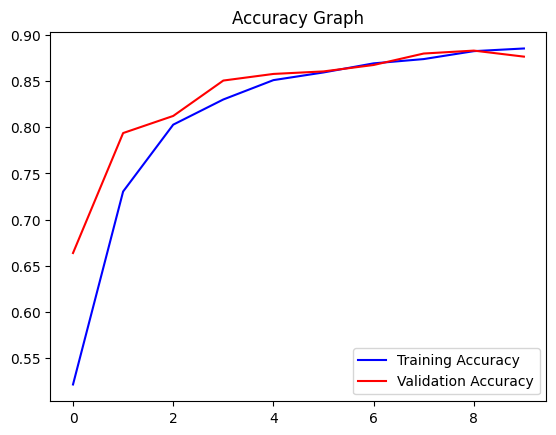

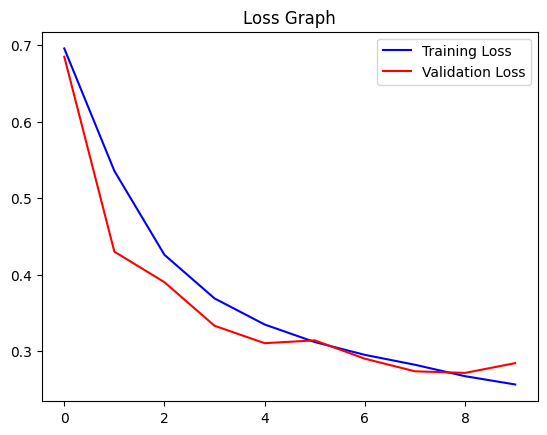

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

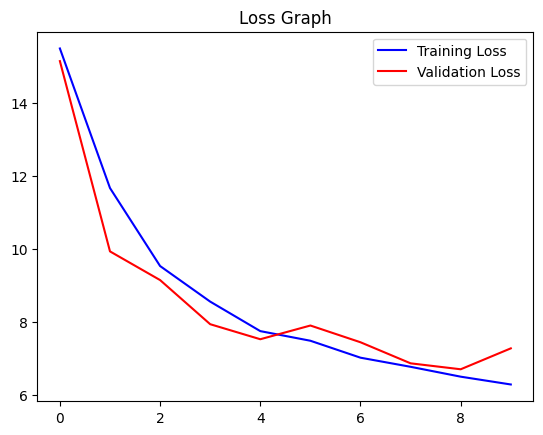

In [23]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Predicting Test Data

In [24]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 350ms/step


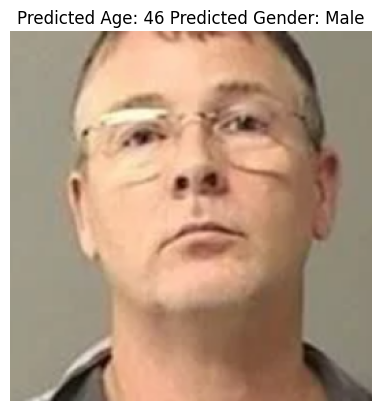

In [30]:
img_to_test = r"C:\Users\pjaga\OneDrive\Desktop\Data Science\Age and Gender Detection System\test images\1.png"
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))